# Прогнозирование уровня средней заработной платы в России

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
# создадим функцию обратного преобразования Бокса-Кокса
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [3]:
# загрузим данные 
wages = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [4]:
wages.shape

(339, 1)

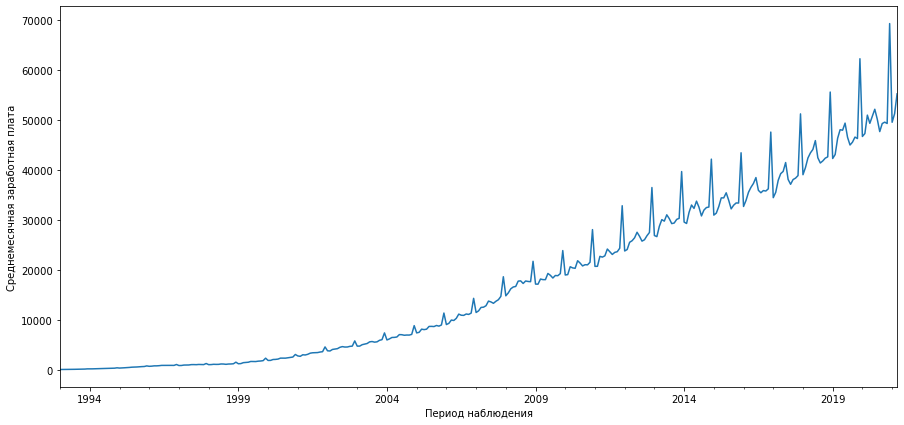

In [5]:
#построим график распределения
plt.figure(figsize(15,7));
wages.WAG_C_M.plot();
plt.xlabel('Период наблюдения');
plt.ylabel('Среднемесячная заработная плата');

Проверим гипотезу нестационарности ряда, применив критерий Дики-Фуллера:
* **Н0** - ряд нестационарен
* **Н1** - ряд стационарен

Уровень значимости alpha = 0.05.

In [6]:
print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(wages.WAG_C_M)[1])

Критерий Дики-Фуллера: p=0.999007


На уровне значимости 0.05 нулевую гипотезу принимаем.


Оценим визуально из каких компонентов состоит ряд, применив STL-декомпозицию.

<Figure size 1080x720 with 0 Axes>

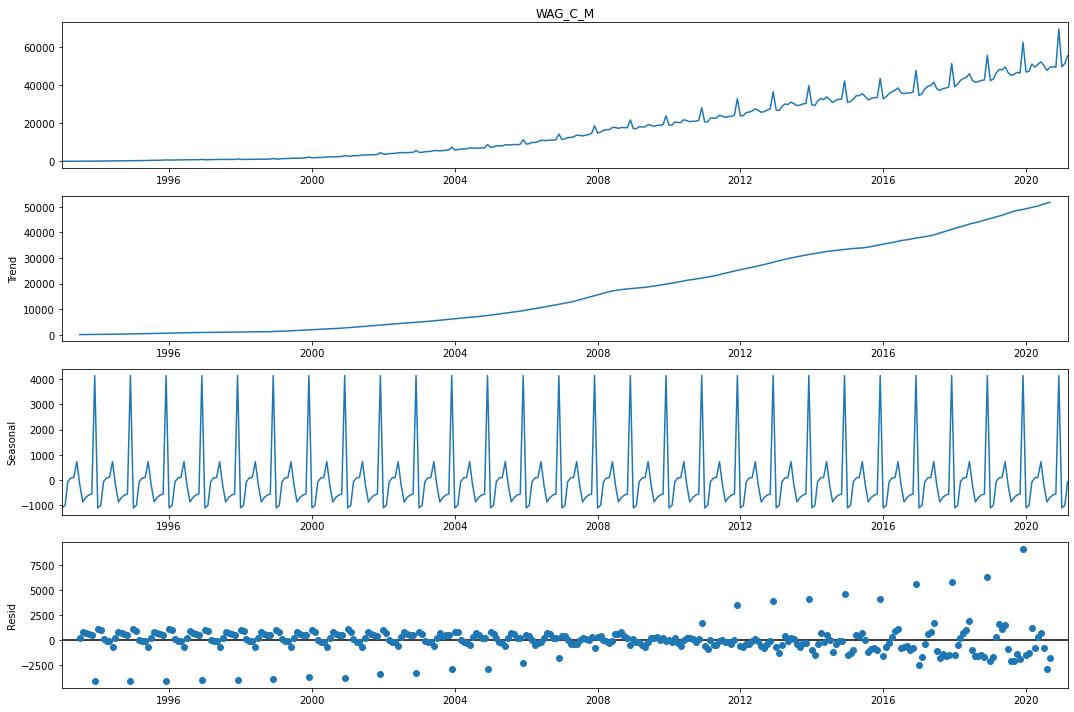

In [7]:
plt.figure(figsize(15,10));
sm.tsa.seasonal_decompose(wages.WAG_C_M).plot();

Анализируя графики, видим:
* Четко выраженный тренд - плавно возрастающая линия
* Явная сезонность
* Дисперсия вначале отличается от значений дисперсии в конце.


Все это подтверждает нестационарность временного ряда.


Для построения модели, приведем ряд к стационарности

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.295192
Критерий Дики-Фуллера: p=0.726438


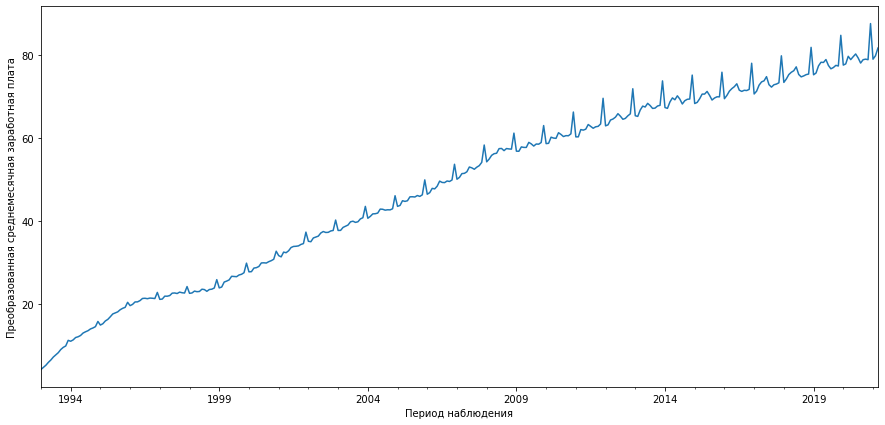

In [8]:
wages['WAG_C_M_box'], lmbda = stats.boxcox(wages.WAG_C_M)
plt.figure(figsize(15,7));
wages.WAG_C_M_box.plot();
plt.xlabel('Период наблюдения');
plt.ylabel('Преобразованная среднемесячная заработная плата');

print('Оптимальный параметр преобразования Бокса-Кокса: %f' % lmbda)
print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(wages.WAG_C_M_box)[1])

### Стационарность

Попробуем сезонное дифференцирование, сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.121064


<Figure size 1080x720 with 0 Axes>

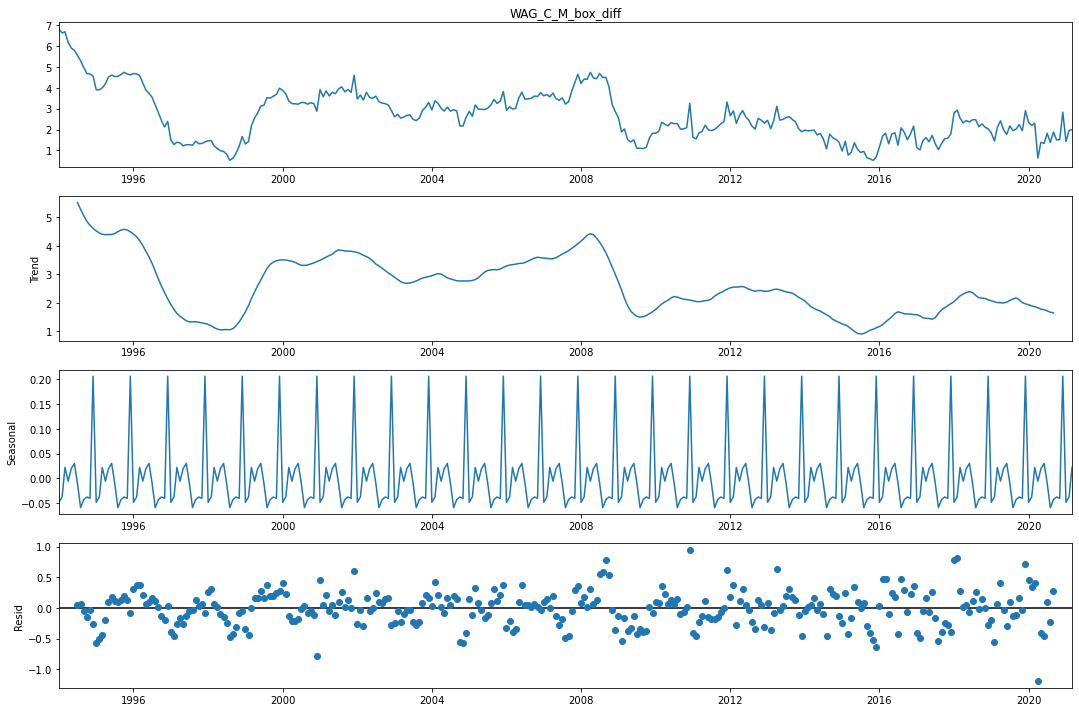

In [9]:
wages['WAG_C_M_box_diff'] = wages.WAG_C_M_box - wages.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10));
sm.tsa.seasonal_decompose(wages.WAG_C_M_box_diff[12:]).plot();

print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(wages.WAG_C_M_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда и сезонности не удалось. Попробуем добавить обычное дифференцирование:

Критерий Дики-Фуллера: p=0.003070


<Figure size 1080x720 with 0 Axes>

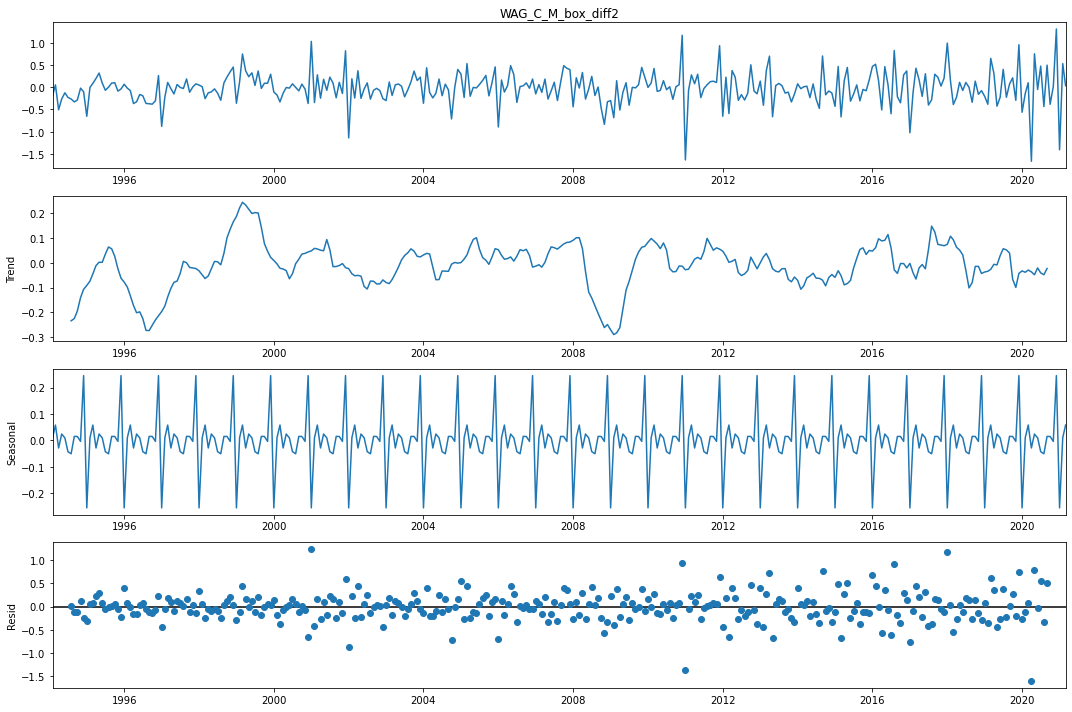

In [10]:
wages['WAG_C_M_box_diff2'] = wages.WAG_C_M_box_diff - wages.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10));
sm.tsa.seasonal_decompose(wages.WAG_C_M_box_diff2[13:]).plot();   

print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(wages.WAG_C_M_box_diff2[13:])[1])

Гипотеза нестационарности на уровне значимости 0.05 отвергается, также удалось минимизировать влияние тренда.

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

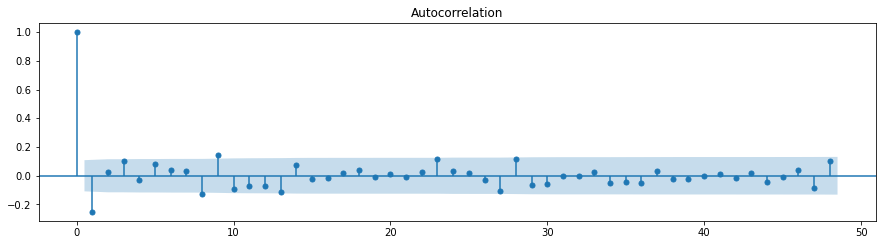

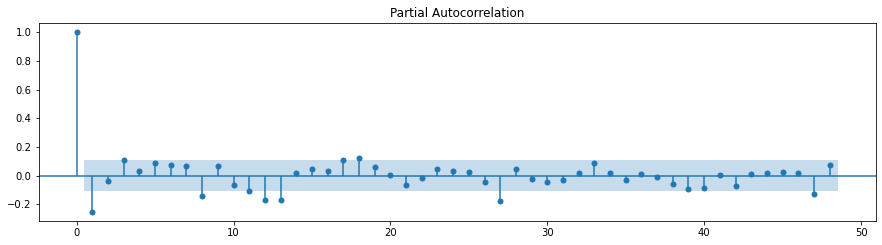

In [11]:
plt.figure(figsize(15,8));
ax = plt.subplot(211);
sm.graphics.tsa.plot_acf(wages.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax);
pylab.show();
ax = plt.subplot(212);
sm.graphics.tsa.plot_pacf(wages.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax);
pylab.show();

Опираясь на графики выберем начальные приближения: Q=0, q=1, P=3, p=1

In [12]:
# переберем возможные значения параметров
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 4)
D=1
Qs = range(0, 1)

In [13]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

Обучим модели для созданных комбинаций параметров. При этом покажем неверные комбинации (на которых модель не обучается) и покажем рассчетное время:

In [14]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wages.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 11 s


Выведем лучшие параметры:

In [15]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
9   (1, 0, 1, 0)  248.192221
10  (1, 0, 2, 0)  248.875641
5   (0, 1, 1, 0)  249.253903
13  (1, 1, 1, 0)  249.620629
11  (1, 0, 3, 0)  249.962906


Лучшая модель:

In [16]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        WAG_C_M_box   No. Observations:                  339
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -121.096
Date:                            Mon, 07 Jun 2021   AIC                            248.192
Time:                                    23:30:52   BIC                            259.553
Sample:                                01-01-1993   HQIC                           252.726
                                     - 03-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2825      0.041     -6.940      0.000      -0.362      -0.203
ar.S.L12      -0.1589      0.042   

Критерий Стьюдента: p=0.263113
Критерий Дики-Фуллера: p=0.000000


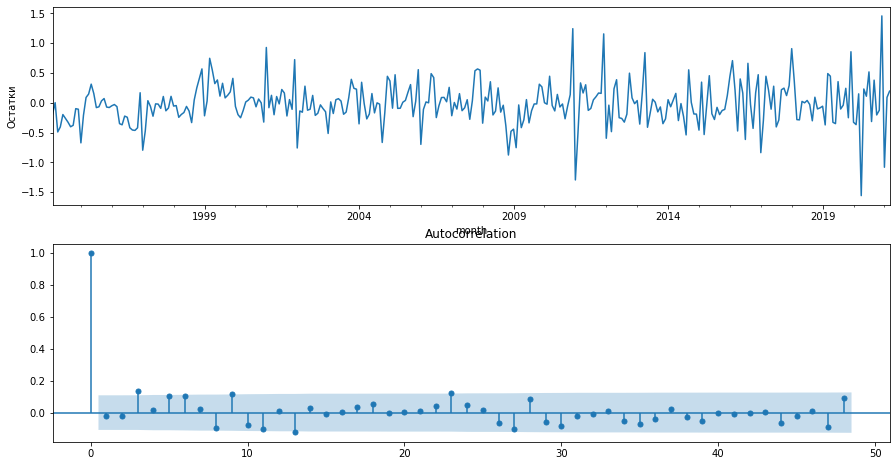

In [17]:
plt.figure(figsize(15,8));
plt.subplot(211);
best_model.resid[13:].plot();
plt.ylabel('Остатки');

ax = plt.subplot(212);
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax);

print('Критерий Стьюдента: p=%f' % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

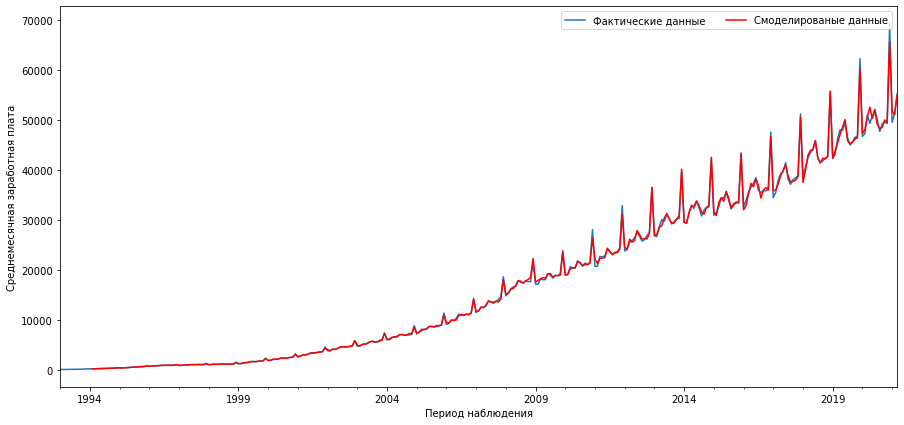

In [18]:
wages['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7));
wages.WAG_C_M.plot();
wages.model[13:].plot(color='r');
plt.xlabel('Период наблюдения');
plt.ylabel('Среднемесячная заработная плата')
plt.legend( ['Фактические данные', 'Смоделированые данные'],
            loc=1, ncol = 2, prop={'size':10});
pylab.show();

### Прогноз

Построим прогноз на два ближайших года:

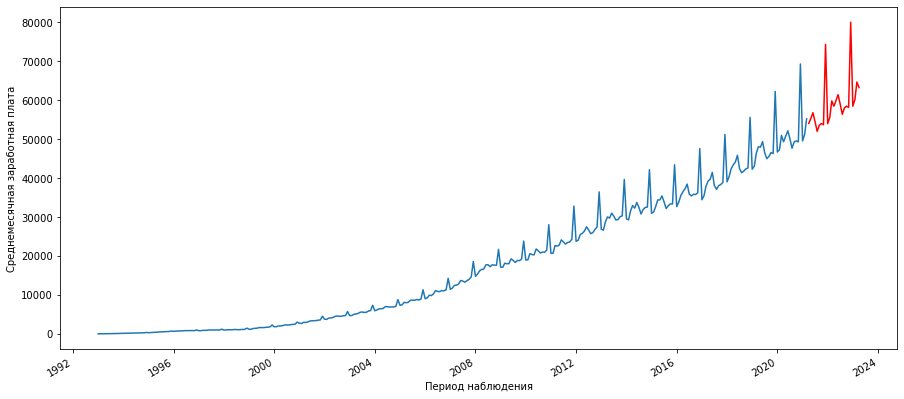

In [19]:
wages2 = wages[['WAG_C_M']]
date_list = [datetime.datetime.strptime('2021-03-01', '%Y-%m-%d') + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wages2.columns)
wages2 = pd.concat([wages2, future])
wages2['forecast'] = invboxcox(best_model.predict(start=339, end=363), lmbda)

plt.figure(figsize(15,7));
wages2.WAG_C_M.plot();
wages2.forecast.plot(color='r');
plt.xlabel('Период наблюдения');
plt.ylabel('Среднемесячная заработная плата');
pylab.show();